# LSTM-CNN Outline
Author: Ding Shuya
1. Motivation
2. Data Loading 
3. Data Preprocessing 

>1. Data Analysis 
>2. Balanced Data Filter
>3. Padding Data
>4. Data Normalization
>5. Categorical

4. Model Structures
>1. Hyperparameter Tuning
5. Training 
>1. Training
>2. Performance Improvment
7. Evaluation 


## 1. Motivation

Encoder-Decoder structures are widely used in seq2seq model and other applications.

Beyond that, CNN has the most outstanding results in image classifications

We hypothesis that RNN-CNN network can deal with incomplete sketches better as this structure take consider the stroke sequence of sketches. Meanwhile, CNN is used for predicting the labels using hidden feature vectors provided by RNN encoder.

## 2. Data Loading

In [3]:
if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()

In [4]:
import sys 
print(sys.executable)

/home/di0002ya/miniconda3/envs/quickdraw/bin/python


In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GRU, LSTM
from keras.layers import Conv2D, MaxPooling2D, Input, Reshape
from keras.layers.convolutional import ZeroPadding2D
from keras.models import load_model
import glob
import os.path as path
import ndjson
import random
import pickle
import numpy as np
import time
import math

Using TensorFlow backend.


Our team will use one preprocessed data raw files for modelling in order to compare results.

In [7]:
import os
import pickle

def _cut_stroke(x,ratio=1):
    if ratio==1:
        return x
    return [i[:int(len(i)*ratio)] for i in x]
def get_dataset(dataset_path='',dataset_name='1102_05b633244.dms',train_r=1.0,test_r=1.0):
    (train_Recognized, train_X, train_Y, test_Recognized, test_X, test_Y)=pickle.load(open(os.path.join(dataset_path,dataset_name),'rb'))
    train_X=_cut_stroke(train_X,train_r)
    test_X=_cut_stroke(test_X,test_r)
    return train_Recognized,train_X,train_Y,test_Recognized,test_X,test_Y

In [8]:
dataset_path='/home/di0002ya/quickdraw/dsy'

In [40]:
train_Recognized,train_X,train_Y,test_Recognized,test_X,test_Y=get_dataset(dataset_path = dataset_path, dataset_name = '1102_05b633244.dms',train_r=1.0,test_r=1.0)

In [41]:
import pandas as pd
df_trainX = pd.DataFrame({'drawing':train_X})
df_testX = pd.DataFrame({'drawing':test_X})
# Calculate Stroke Number of Each Image
df_trainX['stroke_number'] = df_trainX['drawing'].str.len()
df_testX['stroke_number'] = df_testX['drawing'].str.len()

## 3. Data Preprocessing

We will use datasets format which proposed in sketch RNN. Each example in the dataset is stored as list of coordinate offsets: ∆x, ∆y, and a binary value representing whether the pen is lifted away from the paper. 




### 3.1 Data Analysis

1st Structure: Dimension = (samples) * (3* max points of each strokes of all drawings) * (max strokes of all drawings)

2nd Structure: Dimension = (samples) * 3* max points of all drawings


#### 1. 1st Structure

In [15]:
import itertools
def create_stroke(df):
    final = []
    # Image
    for i in range(df.shape[0]):
        num = df.loc[i,'stroke_number']
        # Strokes 
        stroke_ls = []
        for stroke in range(num):
            X = df.loc[i,'drawing'][stroke][0] #points of stroke 
            Y = df.loc[i,'drawing'][stroke][1] #points of stroke
            X_offset = np.diff(np.array(X)) # points of stroke 
            Y_offset = np.diff(np.array(Y)) # points of stroke
            binary = [0]*(X_offset.shape[0]-1)
            binary.append(1) # points of stroke 
            binary = np.array(binary)
            stroke_ar = np.vstack((X_offset,Y_offset,binary)).reshape(-1) 
            stroke_ls.append(stroke_ar)
        final.append(stroke_ls)
    return final

In [16]:
trainX_final = create_stroke(df_trainX)

In [17]:
print('Max stroke is: ', df_trainX[['stroke_number']].max())
print('Min stroke is: ', df_trainX[['stroke_number']].min())

Max stroke is:  stroke_number    30
dtype: int64
Min stroke is:  stroke_number    1
dtype: int64


In [18]:
max_stroke = 0 
min_stroke = 500
for i in range(len(trainX_final)):
    for j in range(len(trainX_final[i])):
        temp = trainX_final[i][j].shape[0]
        if temp < min_stroke:
            min_stroke = temp
        elif temp > max_stroke:
            max_stroke = temp
print('Max dimensions *3 of overall stroke', max_stroke) 
print('Min dimensions *3 of overall stroke', min_stroke)  

Max dimensions *3 of overall stroke 597
Min dimensions *3 of overall stroke 3


As what mentioned above, I will preprocess trainX_final into following dimensions 

1. 1st Structure: **N\*597\*30**

Before this, as our computational resources is limited, only part of training data will be used. In order to eliminate imbalanced data effect, I will use following functions to select balanced data.

### 3.2 Balanced Data filtering

In [19]:
from random import shuffle
def balance_filter(ls, label_list, name, SL, EL):   
    # Get indices list that have balance labels 
    label_ar = np.array(label_list)
    label1_indices = np.array(np.where(label_ar == 0)).reshape(-1)[SL:EL].tolist()
    label2_indices = np.array(np.where(label_ar == 1)).reshape(-1)[SL:EL].tolist()
    label3_indices = np.array(np.where(label_ar == 2)).reshape(-1)[SL:EL].tolist()
    label4_indices = np.array(np.where(label_ar == 3)).reshape(-1)[SL:EL].tolist()
    label5_indices = np.array(np.where(label_ar == 4)).reshape(-1)[SL:EL].tolist()
    train_indices = []
    temp = [label1_indices, label2_indices, label3_indices, label4_indices, label5_indices]
    for i in range(5):
        target = temp[i]
        for item in range(len(target)):
            train_indices.append(target[item])
#     print(train_indices)
    # Shuffle indices
    shuffle(train_indices)
    # Select X & Y
    final_X_ls = []
    final_label_ls = []
    for i in range(len(train_indices)):
#         print('i')
#         print(i)
        indice = train_indices[i]
        #print('indice')
        #print(indice)
        final_X_ls.append(ls[indice])
        final_label_ls.append(label_list[indice])

    final_label_ar = np.array(final_label_ls)
    print(name +'label 0 has', sum(final_label_ar==0))
    print(name +'label 1 has', sum(final_label_ar==1))
    print(name +'label 2 has', sum(final_label_ar==2))
    print(name +'label 3 has', sum(final_label_ar==3))
    print(name + 'label 4 has', sum(final_label_ar==4))

    return final_X_ls, final_label_ar

In [20]:
train_X_balance, train_Y_balance = balance_filter(trainX_final, train_Y, 'train', 0, 3000)

trainlabel 0 has 3000
trainlabel 1 has 3000
trainlabel 2 has 3000
trainlabel 3 has 3000
trainlabel 4 has 3000


In [28]:
train_X_balance_full, train_Y_balance_full = balance_filter(trainX_final, train_Y, 'train', 0, 30000)

trainlabel 0 has 30000
trainlabel 1 has 30000
trainlabel 2 has 30000
trainlabel 3 has 30000
trainlabel 4 has 30000


### 3.3 Padding Data

In order simplifying the RNN training process, we will padding our training data into same time steps length and same dimensions. 

It means that two operations will be done. One is padding points of each stroke of all samples to 597 and padding strokes of each images to 30

In [29]:
def pad_points(data_stroke, max_pts = 597):
    final = []
    for i in range(len(data_stroke)):
        # ith image 
        for j in range(len(data_stroke[i])):
            # jth strokes 
            orig = len(data_stroke[i][j])
            # pts*3 of jth stroke 
            #print(orig)
            if orig < max_pts:
                pad = np.array([0]*(max_pts-orig))
                data_stroke[i][j] = np.hstack((data_stroke[i][j],pad))
            else:
                data_stroke[i][j] = data_stroke[i][j][:max_pts]
            #print(pad.shape)
            #print(data_stroke[i][j].shape)

        final.append(np.array(data_stroke[i]))
            #print(data_stroke[i][j].shape)
    return final

In [30]:
trainX_input = pad_points(train_X_balance)

In [31]:
trainX_full = pad_points(train_X_balance_full)

In [32]:
def pad_stroke(data_stroke, max_stroke, max_pts):
    for i in range(len(data_stroke)):
        # ith image 
        # get No.stroke for this image
        orig = data_stroke[i].shape[0]
        #print(orig)
        pad = np.zeros(((max_stroke-orig),max_pts))
        #print(pad.shape)
        #print(data_stroke[i].shape)
        data_stroke[i] = np.vstack((data_stroke[i],pad))
        #print(data_stroke[i].shape)
    return data_stroke

In [33]:
import numpy as np
trainX_ar = np.array(pad_stroke(trainX_input, max_stroke=30, max_pts=597))

In [34]:
trainX_ar_full = np.array(pad_stroke(trainX_full, max_stroke=30, max_pts=597))

### 3.4 Data Normalization

In [35]:
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical

min_value = trainX_ar.min()
max_value = trainX_ar.max()
X_std = (trainX_ar - min_value) / (max_value - min_value)
X_scaled= X_std * (max_value - min_value) + min_value
categorical_labels = to_categorical(train_Y_balance, num_classes=5)
np.save(dataset_path+'/X_train.npy',X_scaled)
np.save(dataset_path+'/Y_train.npy',categorical_labels)

In [36]:
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical

min_value = trainX_ar_full.min()
max_value = trainX_ar_full.max()
X_std = (trainX_ar_full - min_value) / (max_value - min_value)
X_scaled_full = X_std * (max_value - min_value) + min_value
categorical_labels_full = to_categorical(train_Y_balance_full, num_classes=5)
np.save(dataset_path+'/X_train_full.npy',X_scaled_full)
np.save(dataset_path+'/Y_train_full.npy',categorical_labels_full)

In [45]:
np.save(dataset_path+'/X_train_full.npy',X_scaled_full)

## 4. Model Structure N = 15000

Firstly, we will use only 15000 training data for hyperparameter tuning. Following parameters will be tuned.
1. LSTMUnits
2. Batch
3. Dropout
4. Enc_Dense
5. Num_filters
6. KernelS
7. Dec_dense

We firstly build a simple model. Moreover, dropout layer, maxpooling layer will also be used. Order of these layers will be based on the following rules. 
1. Dropout 
2. Linear/Dense/Conv
3. Batch Normalization
4. Activations
5. Maxpooling

'Relu' will be used after convolutional layer and dense layer. 

Output activation function will be 'softmax' as this is a classification problems. 

Adam is the selected optimizer as Adam is the best optimizer currently. 

Loss function will be 'cross-entropy'. 

#### 4.1 LSTM Units 

In [30]:
LSTM_ls = [10,50,100,300,500]

In [25]:
args = {}
args['LSTMUnits'] = 100
args['batch'] = 256
args['epochs'] = 1
args['dropout'] = 0.2
args['len_category'] = 5
args['enc_dense'] = 256
args['num_filters'] = 1
args['kernelS'] = 3
args['stride'] = 2
args['poolS'] = 2 
args['dec_dense'] = 32

In [ ]:
model_list = []
for i in range(len(LSTM_ls)):
    print(i,'---hyper tuning--')
    #args['LSTMUnits'] = LSTM[i]
    units = LSTM_ls[i]
    print(units)
    model = Sequential()
    model.add(LSTM(units, return_sequences=False, input_dim=597, input_length=30))
    model.add(Dense(args['enc_dense'], activation='relu'))
    model.add(Reshape((16,16,1)))
    model.add(Conv2D(args['num_filters'],args['kernelS'],strides=(args['stride'],args['stride']), activation ='relu'))
    #model.add(MaxPooling2D(pool_size=(args['poolS'],args['poolS'])))
    model.add(Flatten())
    model.add(Dense(args['dec_dense'], activation='relu'))
    model.add(Dropout(args['dropout']))
    model.add(Dense(args['len_category'], activation='softmax'))

    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    model.fit(X_train, categorical_labels,
          batch_size = args['batch'], nb_epoch= args['epochs'], 
          verbose=1,validation_split=0.2)
    model_list.append(model)

Based on above results, we will select **LSTMUnits = 300** 

#### 4.2 Batch

In [43]:
batch_ls = [16,32,64,128,256]

In [44]:
args = {}
args['LSTMUnits'] = 300
args['batch'] = 256
args['epochs'] = 1
args['dropout'] = 0.2
args['len_category'] = 5
args['enc_dense'] = 256
args['num_filters'] = 1
args['kernelS'] = 3
args['stride'] = 2
args['poolS'] = 2 
args['dec_dense'] = 32

In [45]:
for i in range(len(batch_ls)):
    print(i,'---hyper tuning--')
    #args['LSTMUnits'] = LSTM[i]
    units = batch_ls[i]
    print(units)
    model = Sequential()
    model.add(LSTM(args['LSTMUnits'], return_sequences=False, input_dim=597, input_length=30))
    model.add(Dense(args['enc_dense'], activation='relu'))
    model.add(Reshape((16,16,1)))
    model.add(Conv2D(args['num_filters'],args['kernelS'],strides=(args['stride'],args['stride']), activation ='relu'))
    #model.add(MaxPooling2D(pool_size=(args['poolS'],args['poolS'])))
    model.add(Flatten())
    model.add(Dense(args['dec_dense'], activation='relu'))
    model.add(Dropout(args['dropout']))
    model.add(Dense(args['len_category'], activation='softmax'))

    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    model.fit(X_train, categorical_labels,
          batch_size = units, nb_epoch= args['epochs'], 
          verbose=1,validation_split=0.2)


0 ---hyper tuning--
16


/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(300, return_sequences=False, input_shape=(30, 597))`
  
/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 12000 samples, validate on 3000 samples
Epoch 1/1
12000/12000 [==============================] - 44s 4ms/step - loss: 1.3895 - acc: 0.3435 - val_loss: 1.3579 - val_acc: 0.3523
1 ---hyper tuning--
32
Train on 12000 samples, validate on 3000 samples
Epoch 1/1
12000/12000 [==============================] - 28s 2ms/step - loss: 1.3099 - acc: 0.4237 - val_loss: 1.0563 - val_acc: 0.5883
2 ---hyper tuning--
64
Train on 12000 samples, validate on 3000 samples
Epoch 1/1
12000/12000 [==============================] - 20s 2ms/step - loss: 1.2991 - acc: 0.4220 - val_loss: 1.1296 - val_acc: 0.5157
3 ---hyper tuning--
128
Train on 12000 samples, validate on 3000 samples
Epoch 1/1
12000/12000 [==============================] - 17s 1ms/step - loss: 1.5304 - acc: 0.2946 - val_loss: 1.5288 - val_acc: 0.2873
4 ---hyper tuning--
256
Train on 12000 samples, validate on 3000 samples
Epoch 1/1
12000/12000 [==============================] - 16s 1ms/step - loss: 1.4147 - acc: 0.3369 - val_loss: 1.3212

Based on above results, we will select **Batch = 32**

#### 4.3 Dropout

In [47]:
dropout_ls = [0.2,0.4,0.6]
args = {}
args['LSTMUnits'] = 300
args['batch'] = 32
args['epochs'] = 1
args['len_category'] = 5
args['enc_dense'] = 256
args['num_filters'] = 1
args['kernelS'] = 3
args['stride'] = 2
args['poolS'] = 2 
args['dec_dense'] = 32

In [48]:

for i in range(len(dropout_ls)):
    print(i,'---hyper tuning--')
    #args['LSTMUnits'] = LSTM[i]
    units = dropout_ls[i]
    print(units)
    args['dropout'] = units
    model = Sequential()
    model.add(LSTM(args['LSTMUnits'], return_sequences=False, input_dim=597, input_length=30))
    model.add(Dense(args['enc_dense'], activation='relu'))
    model.add(Reshape((16,16,1)))
    model.add(Conv2D(args['num_filters'],args['kernelS'],strides=(args['stride'],args['stride']), activation ='relu'))
    #model.add(MaxPooling2D(pool_size=(args['poolS'],args['poolS'])))
    model.add(Flatten())
    model.add(Dense(args['dec_dense'], activation='relu'))
    model.add(Dropout(args['dropout']))
    model.add(Dense(args['len_category'], activation='softmax'))

    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    model.fit(X_train, categorical_labels,
          batch_size = args['batch'], nb_epoch= args['epochs'], 
          verbose=1,validation_split=0.2)

0 ---hyper tuning--
0.2


/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  if __name__ == '__main__':
/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(300, return_sequences=False, input_shape=(30, 597))`
  if __name__ == '__main__':
/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 12000 samples, validate on 3000 samples
Epoch 1/1
12000/12000 [==============================] - 28s 2ms/step - loss: 1.3549 - acc: 0.3813 - val_loss: 1.2819 - val_acc: 0.4343
1 ---hyper tuning--
0.4
Train on 12000 samples, validate on 3000 samples
Epoch 1/1
12000/12000 [==============================] - 29s 2ms/step - loss: 1.3896 - acc: 0.3465 - val_loss: 1.3084 - val_acc: 0.4323
2 ---hyper tuning--
0.6
Train on 12000 samples, validate on 3000 samples
Epoch 1/1
12000/12000 [==============================] - 29s 2ms/step - loss: 1.4925 - acc: 0.3061 - val_loss: 1.4063 - val_acc: 0.3530


Based on above results, we will select **Dropout = 0.2**

#### 4.4 Encoder Dense Units

In [50]:
encdense_ls = [64, 256, 324, 1024 ]
args = {}
args['LSTMUnits'] = 300
args['batch'] = 32
args['epochs'] = 1
args['len_category'] = 5
args['num_filters'] = 1
args['kernelS'] = 3
args['stride'] = 2
args['poolS'] = 2 
args['dec_dense'] = 32
args['dropout'] = 0.2 

In [52]:

for i in range(len(encdense_ls)):
    print(i,'---hyper tuning--')
    #args['LSTMUnits'] = LSTM[i]
    units = encdense_ls[i]
    print(units)
    args['enc_dense'] = units
    args['sqrt_enc_dense'] = int(math.sqrt(units))
    model = Sequential()
    model.add(LSTM(args['LSTMUnits'], return_sequences=False, input_dim=597, input_length=30))
    model.add(Dense(args['enc_dense'], activation='relu'))
    model.add(Reshape((args['sqrt_enc_dense'] ,args['sqrt_enc_dense'],1)))
    model.add(Conv2D(args['num_filters'],args['kernelS'],strides=(args['stride'],args['stride']), activation ='relu'))
    #model.add(MaxPooling2D(pool_size=(args['poolS'],args['poolS'])))
    model.add(Flatten())
    model.add(Dense(args['dec_dense'], activation='relu'))
    model.add(Dropout(args['dropout']))
    model.add(Dense(args['len_category'], activation='softmax'))

    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    model.fit(X_train, categorical_labels,
          batch_size = args['batch'], nb_epoch= args['epochs'], 
          verbose=1,validation_split=0.2)

0 ---hyper tuning--
64


/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(300, return_sequences=False, input_shape=(30, 597))`
  # Remove the CWD from sys.path while we load stuff.
/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 12000 samples, validate on 3000 samples
Epoch 1/1
12000/12000 [==============================] - 29s 2ms/step - loss: 1.3662 - acc: 0.3889 - val_loss: 1.2704 - val_acc: 0.4237
1 ---hyper tuning--
256
Train on 12000 samples, validate on 3000 samples
Epoch 1/1
12000/12000 [==============================] - 30s 2ms/step - loss: 1.3427 - acc: 0.3822 - val_loss: 1.1955 - val_acc: 0.4923
2 ---hyper tuning--
324
Train on 12000 samples, validate on 3000 samples
Epoch 1/1
12000/12000 [==============================] - 30s 2ms/step - loss: 1.3754 - acc: 0.3483 - val_loss: 1.3568 - val_acc: 0.3573
3 ---hyper tuning--
1024
Train on 12000 samples, validate on 3000 samples
Epoch 1/1
12000/12000 [==============================] - 31s 3ms/step - loss: 1.3662 - acc: 0.3532 - val_loss: 1.3402 - val_acc: 0.3463


Based on above results, we will select **Encoder Dense Units = 256**

#### 4.5  Num_filters

In [54]:
filter_ls = [8,16,32,64]
args = {}
args['LSTMUnits'] = 300
args['batch'] = 32
args['enc_dense']= 256
args['sqrt_enc_dense'] = 16
args['epochs'] = 1
args['len_category'] = 5
args['kernelS'] = 3
args['stride'] = 2
args['poolS'] = 2 
args['dec_dense'] = 32
args['dropout'] = 0.2 

In [56]:
for i in range(len(filter_ls)):
    print(i,'---hyper tuning--')
    #args['LSTMUnits'] = LSTM[i]
    units = filter_ls[i]
    print(units)
    args['num_filters'] = units
    model = Sequential()
    model.add(LSTM(args['LSTMUnits'], return_sequences=False, input_dim=597, input_length=30))
    model.add(Dense(args['enc_dense'], activation='relu'))
    model.add(Reshape((args['sqrt_enc_dense'] ,args['sqrt_enc_dense'],1)))
    model.add(Conv2D(args['num_filters'],args['kernelS'],strides=(args['stride'],args['stride']), activation ='relu'))
    #model.add(MaxPooling2D(pool_size=(args['poolS'],args['poolS'])))
    model.add(Flatten())
    model.add(Dense(args['dec_dense'], activation='relu'))
    model.add(Dropout(args['dropout']))
    model.add(Dense(args['len_category'], activation='softmax'))

    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    model.fit(X_train, categorical_labels,
          batch_size = args['batch'], nb_epoch= args['epochs'], 
          verbose=1,validation_split=0.2)

0 ---hyper tuning--
8


/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(300, return_sequences=False, input_shape=(30, 597))`
  
/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 12000 samples, validate on 3000 samples
Epoch 1/1
12000/12000 [==============================] - 30s 2ms/step - loss: 1.3624 - acc: 0.3682 - val_loss: 1.2423 - val_acc: 0.4873
1 ---hyper tuning--
16
Train on 12000 samples, validate on 3000 samples
Epoch 1/1
12000/12000 [==============================] - 31s 3ms/step - loss: 1.3629 - acc: 0.3808 - val_loss: 1.3291 - val_acc: 0.4273
2 ---hyper tuning--
32
Train on 12000 samples, validate on 3000 samples
Epoch 1/1
12000/12000 [==============================] - 31s 3ms/step - loss: 1.3378 - acc: 0.4024 - val_loss: 1.1866 - val_acc: 0.5207
3 ---hyper tuning--
64
Train on 12000 samples, validate on 3000 samples
Epoch 1/1
12000/12000 [==============================] - 32s 3ms/step - loss: 1.3511 - acc: 0.3838 - val_loss: 1.2226 - val_acc: 0.4843


Based on above results, we will select **Number of filters = 32**

#### 4.6  Filter Size

In [58]:
filter_ls = [3,5,7]
args = {}
args['LSTMUnits'] = 300
args['batch'] = 32
args['enc_dense']= 256
args['sqrt_enc_dense'] = 16
args['epochs'] = 1
args['len_category'] = 5
args['kernelS'] = 3
args['stride'] = 2
args['poolS'] = 2 
args['num_filters'] = 32
args['dec_dense'] = 32
args['dropout'] = 0.2 

In [59]:
for i in range(len(filter_ls)):
    print(i,'---hyper tuning--')
    #args['LSTMUnits'] = LSTM[i]
    units = filter_ls[i]
    print(units)
    args['kernelS'] = units
    model = Sequential()
    model.add(LSTM(args['LSTMUnits'], return_sequences=False, input_dim=597, input_length=30))
    model.add(Dense(args['enc_dense'], activation='relu'))
    model.add(Reshape((args['sqrt_enc_dense'] ,args['sqrt_enc_dense'],1)))
    model.add(Conv2D(args['num_filters'],args['kernelS'],strides=(args['stride'],args['stride']), activation ='relu'))
    #model.add(MaxPooling2D(pool_size=(args['poolS'],args['poolS'])))
    model.add(Flatten())
    model.add(Dense(args['dec_dense'], activation='relu'))
    model.add(Dropout(args['dropout']))
    model.add(Dense(args['len_category'], activation='softmax'))

    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    model.fit(X_train, categorical_labels,
          batch_size = args['batch'], nb_epoch= args['epochs'], 
          verbose=1,validation_split=0.2)

0 ---hyper tuning--
3


/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(300, return_sequences=False, input_shape=(30, 597))`
  
/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 12000 samples, validate on 3000 samples
Epoch 1/1
12000/12000 [==============================] - 32s 3ms/step - loss: 1.3550 - acc: 0.3935 - val_loss: 1.2636 - val_acc: 0.4673
1 ---hyper tuning--
5
Train on 12000 samples, validate on 3000 samples
Epoch 1/1
12000/12000 [==============================] - 32s 3ms/step - loss: 1.3907 - acc: 0.3573 - val_loss: 1.2868 - val_acc: 0.4157
2 ---hyper tuning--
7
Train on 12000 samples, validate on 3000 samples
Epoch 1/1
12000/12000 [==============================] - 32s 3ms/step - loss: 1.3636 - acc: 0.3741 - val_loss: 1.1641 - val_acc: 0.5100


Based on above results, we will select **Filter Size = 7**

#### 4.7  Decoder Dense Units

In [61]:
filter_ls = [16,32,64,128]
args = {}
args['LSTMUnits'] = 300
args['batch'] = 32
args['enc_dense']= 256
args['sqrt_enc_dense'] = 16
args['epochs'] = 1
args['len_category'] = 5
args['kernelS'] = 7
args['stride'] = 2
args['poolS'] = 2 
args['num_filters'] = 32
args['dec_dense'] = 32
args['dropout'] = 0.2 

In [62]:
for i in range(len(filter_ls)):
    print(i,'---hyper tuning--')
    #args['LSTMUnits'] = LSTM[i]
    units = filter_ls[i]
    print(units)
    args['dec_dense'] = units
    model = Sequential()
    model.add(LSTM(args['LSTMUnits'], return_sequences=False, input_dim=597, input_length=30))
    model.add(Dense(args['enc_dense'], activation='relu'))
    model.add(Reshape((args['sqrt_enc_dense'] ,args['sqrt_enc_dense'],1)))
    model.add(Conv2D(args['num_filters'],args['kernelS'],strides=(args['stride'],args['stride']), activation ='relu'))
    #model.add(MaxPooling2D(pool_size=(args['poolS'],args['poolS'])))
    model.add(Flatten())
    model.add(Dense(args['dec_dense'], activation='relu'))
    model.add(Dropout(args['dropout']))
    model.add(Dense(args['len_category'], activation='softmax'))

    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    model.fit(X_train, categorical_labels,
          batch_size = args['batch'], nb_epoch= args['epochs'], 
          verbose=1,validation_split=0.2)

0 ---hyper tuning--
16


/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(300, return_sequences=False, input_shape=(30, 597))`
  
/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 12000 samples, validate on 3000 samples
Epoch 1/1
12000/12000 [==============================] - 34s 3ms/step - loss: 1.3916 - acc: 0.3515 - val_loss: 1.3378 - val_acc: 0.3693
1 ---hyper tuning--
32
Train on 12000 samples, validate on 3000 samples
Epoch 1/1
12000/12000 [==============================] - 33s 3ms/step - loss: 1.3550 - acc: 0.3977 - val_loss: 1.2319 - val_acc: 0.4727
2 ---hyper tuning--
64
Train on 12000 samples, validate on 3000 samples
Epoch 1/1
12000/12000 [==============================] - 34s 3ms/step - loss: 1.3473 - acc: 0.3882 - val_loss: 1.3192 - val_acc: 0.4407
3 ---hyper tuning--
128
Train on 12000 samples, validate on 3000 samples
Epoch 1/1
12000/12000 [==============================] - 35s 3ms/step - loss: 1.3588 - acc: 0.3633 - val_loss: 1.3548 - val_acc: 0.3793


Based on above results, we will select **Decoder Dense Units = 32**

## 5. Training

### 5.1 Training: N = 150000

In [8]:
TrainX = np.load(dataset_path+'/X_train_full.npy')
TrainY = np.load(dataset_path+'/Y_train_full.npy')

In [16]:
args = {}
args['LSTMUnits'] = 300
args['batch'] = 128
args['enc_dense']= 256
args['sqrt_enc_dense'] = 16
args['epochs'] = 20
args['len_category'] = 5
args['kernelS'] = 7
args['stride'] = 2
args['poolS'] = 2 
args['num_filters'] = 32
args['dec_dense'] = 32
args['dropout'] = 0.2 

In [17]:
import keras
model = Sequential()
model.add(LSTM(args['LSTMUnits'], return_sequences=False, input_dim=597, input_length=30))
model.add(Dense(args['enc_dense'], activation='relu'))
model.add(Reshape((args['sqrt_enc_dense'],args['sqrt_enc_dense'],1)))
model.add(Conv2D(args['num_filters'],args['kernelS'],strides=(args['stride'],args['stride']), activation ='relu'))
#model.add(MaxPooling2D(pool_size=(args['poolS'],args['poolS'])))
model.add(Flatten())
model.add(Dense(args['dec_dense'], activation='relu'))
model.add(Dropout(args['dropout']))
model.add(Dense(args['len_category'], activation='softmax'))
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
model.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])
model.fit(TrainX, TrainY,
      batch_size = args['batch'], nb_epoch= args['epochs'], 
      verbose=2,validation_split=0.2)

/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(300, return_sequences=False, input_shape=(30, 597))`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 120000 samples, validate on 30000 samples
Epoch 1/20
 - 105s - loss: 0.7115 - acc: 0.7450 - val_loss: 0.4736 - val_acc: 0.8427
Epoch 2/20
 - 104s - loss: 0.4323 - acc: 0.8598 - val_loss: 0.4206 - val_acc: 0.8580
Epoch 3/20
 - 104s - loss: 0.3576 - acc: 0.8851 - val_loss: 0.4225 - val_acc: 0.8628
Epoch 4/20
 - 104s - loss: 0.3135 - acc: 0.8997 - val_loss: 0.4063 - val_acc: 0.8677
Epoch 5/20
 - 103s - loss: 0.2816 - acc: 0.9095 - val_loss: 0.4016 - val_acc: 0.8690
Epoch 6/20
 - 104s - loss: 0.2538 - acc: 0.9201 - val_loss: 0.4349 - val_acc: 0.8729
Epoch 7/20
 - 104s - loss: 0.2323 - acc: 0.9259 - val_loss: 0.4153 - val_acc: 0.8769
Epoch 8/20
 - 105s - loss: 0.2126 - acc: 0.9330 - val_loss: 0.4208 - val_acc: 0.8708
Epoch 9/20
 - 104s - loss: 0.1987 - acc: 0.9365 - val_loss: 0.4200 - val_acc: 0.8746
Epoch 10/20
 - 105s - loss: 0.1845 - acc: 0.9408 - val_loss: 0.4845 - val_acc: 0.8715
Epoch 11/20
 - 105s - loss: 0.1694 - acc: 0.9460 - val_loss: 0.4658 - val_acc: 0.8743
Epoch 12/20


In [22]:
model.save(dataset_path+'/lstm_cnn_full1.h5')

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 300)               1077600   
_________________________________________________________________
dense_7 (Dense)              (None, 256)               77056     
_________________________________________________________________
reshape_3 (Reshape)          (None, 16, 16, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 32)          1600      
_________________________________________________________________
flatten_3 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                25632     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
__________

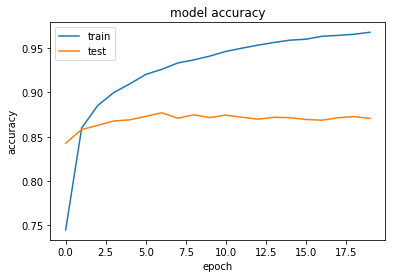

In [24]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

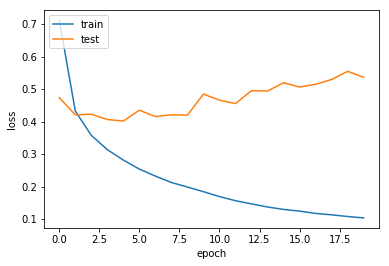

In [25]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

We could see that after 5 epochs, model steps into quickly **overfitting phase**. We need to solve this problem to improve the performance. 

### 5.2 Performance Improvement

During training, callback of early stopping is used. Patience is set to 5 epochs. We could see that the model quickly overfitting. 

Following strategy is used:
1. Increase max pooling size
2. Increase dropout rate
3. Add one more dropout layer
4. Reduce structure dense neurons

In [26]:
args = {}
args['LSTMUnits'] = 300
args['batch'] = 128
args['enc_dense']= 256
args['sqrt_enc_dense'] = 16
args['epochs'] = 20
args['len_category'] = 5
args['kernelS'] = 7
args['stride'] = 2
args['poolS'] = 2 
args['num_filters'] = 32
args['dec_dense'] = 32
args['dropout'] = 0.4

In [27]:
model = Sequential()
model.add(LSTM(args['LSTMUnits'], return_sequences=False, input_dim=597, input_length=30))
model.add(Dropout(args['dropout']))
model.add(Dense(args['enc_dense'], activation='relu'))
model.add(Dropout(args['dropout']))
model.add(Reshape((args['sqrt_enc_dense'],args['sqrt_enc_dense'],1)))
model.add(Conv2D(args['num_filters'],args['kernelS'],strides=(args['stride'],args['stride']), activation ='relu'))
model.add(MaxPooling2D(pool_size=(args['poolS'],args['poolS'])))
model.add(Flatten())
model.add(Dropout(args['dropout']))
model.add(Dense(args['dec_dense'], activation='relu'))
model.add(Dropout(args['dropout']))
model.add(Dense(args['len_category'], activation='softmax'))
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])
model.fit(TrainX, TrainY,
      batch_size = args['batch'], nb_epoch= args['epochs'], 
      verbose=2,validation_split=0.2)

/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(300, return_sequences=False, input_shape=(30, 597))`
  
/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 120000 samples, validate on 30000 samples
Epoch 1/20
 - 104s - loss: 0.8625 - acc: 0.6733 - val_loss: 0.5826 - val_acc: 0.8071
Epoch 2/20
 - 102s - loss: 0.5222 - acc: 0.8373 - val_loss: 0.4511 - val_acc: 0.8494
Epoch 3/20
 - 102s - loss: 0.4324 - acc: 0.8675 - val_loss: 0.4504 - val_acc: 0.8548
Epoch 4/20
 - 102s - loss: 0.3855 - acc: 0.8828 - val_loss: 0.4291 - val_acc: 0.8597
Epoch 5/20
 - 103s - loss: 0.3486 - acc: 0.8940 - val_loss: 0.4287 - val_acc: 0.8646
Epoch 6/20
 - 103s - loss: 0.3177 - acc: 0.9033 - val_loss: 0.4093 - val_acc: 0.8688
Epoch 7/20
 - 103s - loss: 0.2961 - acc: 0.9104 - val_loss: 0.4133 - val_acc: 0.8655
Epoch 8/20
 - 102s - loss: 0.2772 - acc: 0.9158 - val_loss: 0.4031 - val_acc: 0.8702
Epoch 9/20
 - 103s - loss: 0.2565 - acc: 0.9225 - val_loss: 0.4113 - val_acc: 0.8719
Epoch 10/20
 - 103s - loss: 0.2458 - acc: 0.9254 - val_loss: 0.4228 - val_acc: 0.8671
Epoch 11/20
 - 101s - loss: 0.2268 - acc: 0.9324 - val_loss: 0.4263 - val_acc: 0.8722
Epoch 12/20


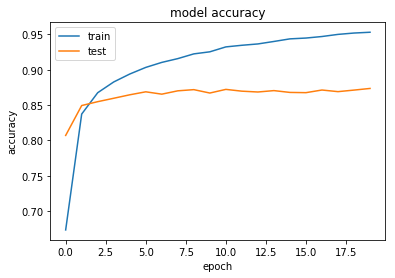

In [28]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

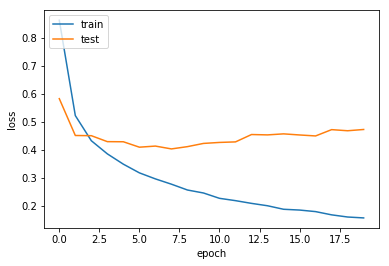

In [29]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

In [30]:
model.save(dataset_path+'/lstm_cnn_full1_tune.h5')

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 300)               1077600   
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               77056     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 16, 16, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 32)          1600      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 32)          0         
__________

## 6. Evaluation 

In [14]:
from keras.models import load_model
full_M = load_model(dataset_path+'/lstm_cnn_full1_tune.h5')

In [15]:
from sklearn.metrics import accuracy_score
import pandas as pd
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn import preprocessing

In [2]:
import itertools
def create_stroke(df):
    final = []
    # Image
    for i in range(df.shape[0]):
        num = df.loc[i,'stroke_number']
        # Strokes 
        stroke_ls = []
        for stroke in range(num):
            X = df.loc[i,'drawing'][stroke][0] #points of stroke 
            Y = df.loc[i,'drawing'][stroke][1] #points of stroke
            X_offset = np.diff(np.array(X)) # points of stroke 
            Y_offset = np.diff(np.array(Y)) # points of stroke
            binary = [0]*(X_offset.shape[0]-1)
            binary.append(1) # points of stroke 
            binary = np.array(binary)
            stroke_ar = np.vstack((X_offset,Y_offset,binary)).reshape(-1) 
            stroke_ls.append(stroke_ar)
        final.append(stroke_ls)
    return final

def pad_points(data_stroke, max_pts = 597):
    final = []
    for i in range(len(data_stroke)):
        # ith image 
        for j in range(len(data_stroke[i])):
            # jth strokes 
            orig = len(data_stroke[i][j])
            # pts*3 of jth stroke 
            #print(orig)
            if orig < max_pts:
                pad = np.array([0]*(max_pts-orig))
                data_stroke[i][j] = np.hstack((data_stroke[i][j],pad))
            else:
                data_stroke[i][j] = data_stroke[i][j][:max_pts]
            #print(pad.shape)
            #print(data_stroke[i][j].shape)

        final.append(np.array(data_stroke[i]))
            #print(data_stroke[i][j].shape)
    return final

def pad_stroke(data_stroke, max_stroke, max_pts):
    for i in range(len(data_stroke)):
        # ith image 
        # get No.stroke for this image
        orig = data_stroke[i].shape[0]
        #print(orig)
        pad = np.zeros(((max_stroke-orig),max_pts))
        #print(pad.shape)
        #print(data_stroke[i].shape)
        data_stroke[i] = np.vstack((data_stroke[i],pad))
        #print(data_stroke[i].shape)
    return data_stroke

def filter_zero(df):
    for i in range(df.shape[0]):
        num = df.loc[i,'stroke_number']
        if num == 0:
            df = df.drop([i])
    df = df.reindex(np.arange(df.shape[0]))                
    return df

In [15]:
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical
ratio = 0.5
_,_,_,_,test_X,test_Y=get_dataset(dataset_path = dataset_path, dataset_name = '1102_05b633244.dms',train_r=1.0,test_r=ratio)
df_testX = pd.DataFrame({'drawing':test_X})
df_testX['stroke_number'] = df_testX['drawing'].str.len()
stroke_num = df_testX['stroke_number']
#Non Zero Filter Out
non_zero_index = np.where(np.array(stroke_num)!=0)
test_Y_filter = np.array(test_Y)[non_zero_index[0]]
df_testX['stroke_number'].replace(0, np.nan, inplace=True)
df_testX.dropna(subset=['stroke_number'], inplace=True)
df_testX = df_testX.reset_index(drop=True)
df_testX['stroke_number'] = df_testX['stroke_number'].astype(int) 
testX_final = create_stroke(df_testX)
testX_input = pad_points(testX_final, max_pts = 597)
testX_ar = np.array(pad_stroke(testX_input, max_stroke=30, max_pts=597))
#Normalization
min_value = testX_ar.min()
max_value = testX_ar.max()
X_std = (testX_ar - min_value) / (max_value - min_value)
X_test = X_std * (max_value - min_value) + min_value
testY_label = to_categorical(test_Y_filter, num_classes=5)
# np.save('/home/di0002ya/quickdraw/dsy/testX'+name+'.npy', testX)
# np.save('/home/di0002ya/quickdraw/dsy/testY'+name+'_label.npy', testY_label)
y_predict = model.predict(X_test)
y_predict_label = np.argmax(y_predict,axis = 1)
y_test_label = np.argmax(testY_label,axis=1)
result = accuracy_score(y_test_label, y_predict_label)
print(result)


0.7010922241136369


In [13]:
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical
import pandas as pd
def compute_result(ratio,name,model):
    print(ratio)
    _,_,_,_,test_X,test_Y=get_dataset(dataset_path = dataset_path, dataset_name = '1102_05b633244.dms',train_r=1.0,test_r=ratio)
    df_testX = pd.DataFrame({'drawing':test_X})
    df_testX['stroke_number'] = df_testX['drawing'].str.len()
    stroke_num = df_testX['stroke_number']
    #Non Zero Filter Out
    non_zero_index = np.where(np.array(stroke_num)!=0)
    test_Y_filter = np.array(test_Y)[non_zero_index[0]]
    df_testX['stroke_number'].replace(0, np.nan, inplace=True)
    df_testX.dropna(subset=['stroke_number'], inplace=True)
    df_testX = df_testX.reset_index(drop=True)
    df_testX['stroke_number'] = df_testX['stroke_number'].astype(int) 
    testX_final = create_stroke(df_testX)
    testX_input = pad_points(testX_final, max_pts = 597)
    testX_ar = np.array(pad_stroke(testX_input, max_stroke=30, max_pts=597))
    #Normalization
    min_value = testX_ar.min()
    max_value = testX_ar.max()
    X_std = (testX_ar - min_value) / (max_value - min_value)
    X_test = X_std * (max_value - min_value) + min_value
    testY_label = to_categorical(test_Y_filter, num_classes=5)
    np.save('/home/di0002ya/quickdraw/dsy/lstm_testX'+name+'.npy', X_test)
    np.save('/home/di0002ya/quickdraw/dsy/lstm_testY'+name+'_label.npy', testY_label)
    y_predict = model.predict(X_test)
    y_predict_label = np.argmax(y_predict,axis = 1)
    y_test_label = np.argmax(testY_label,axis=1)
    result = accuracy_score(y_test_label, y_predict_label)
    print(result)
    

In [17]:
compute_result(0.7,'07',full_M)

0.7
0.7893742313299722


In [18]:
compute_result(0.9,'09',full_M)

0.9
0.8412080438518615


In [19]:
compute_result(1,'10',full_M)

1
0.8727980481488208
